In [1]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
import glob
import shutil
import copy
from sklearn.metrics import r2_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.integrate import solve_ivp 
from sklearn.cluster import KMeans, DBSCAN

from collections import defaultdict
from IPython.core.debugger import set_trace
from IPython.display import clear_output
from easydict import EasyDict

import numpy as np
from scipy.integrate import odeint, solve_ivp

# number of colors in cmap
N_CMAP = 256

# default 
plt.rcParams['font.size'] = 40
plt.rcParams['axes.linewidth'] = 3

%autoreload 2

In [2]:
# from initialnet import initialnet

In [4]:
# N=4
# p=0.5
# R = 1
# gamma=1
# # W_init = initialnet(N, p, R, gamma)

In [5]:
# plt.imshow(np.triu(np.ones((N,N)),-1))

In [6]:
# plt.imshow(W_init)

# train neuronal gains

In [92]:
def f_linear(X, params):
    return X



def f_non_linear(X, params):
    '''
    X - [N,1]
    '''
    out = np.zeros_like(X)
    I = X < 0
    out[I] = params['r0'] * np.tanh(params['gains'][I] * X[I] / params['r0'])
    I2 = ~I
    out[I2] = (params['rmax'] - params['r0']) * np.tanh(params['gains'][I2] * X[I2] / (params['rmax'] - params['r0']))
    return out



def f_final_non_linear(X,params):
    '''
    X - [T,N]
    '''
    gains = params['gains']
#     param.gains = repmat((param.gains)', length(X),1)
    gains = np.tile(gains, (len(X),1))
    
    out = np.zeros_like(X)
    I = X < 0
    out[I] = params['r0'] * np.tanh(gains[I] * X[I] / params['r0'])
    I2 = ~I
    out[I2] = (params['rmax'] - params['r0']) * np.tanh(gains[I2] * X[I2] / (params['rmax'] - params['r0']))
    return out



def integrate_dynamics(W, gains, params, initial_cond):
    
    params['gains'] = gains
    
    def rate_dynamics_ode (t, X, W, params):
        return params['over_tau'] * (-X + np.dot(W, params.f(X, params)))

    # Add noise to the initial condition if indicated
    if params['initial_cond_noise'] != 0:
        initial_cond = initial_cond + np.random.normal(scale=params['initial_cond_noise'], size=initial_cond.shape)

    # Solve the ODEs governing the neuronal dynamics,
    t_span = [0, params['tfinal']]
    t_eval = np.linspace(*t_span, params['n_timepoints'])
    # fun, t_span, y0
    result = solve_ivp(rate_dynamics_ode, t_span, initial_cond, args=(W, params), t_eval=t_eval)
    X = result.y.T # [T,N]

    # Convert neuronal activities into firing rates
    R = params.ff(X, params)

    return {'t': t_eval, 'R': R, 'param': params, 'X':X}

In [93]:
# np.tile(np.arange(3), (4,1)).shape

In [94]:
def readout_fun(X_exc, readout):
    '''
    X - [T,N//2]
    '''
    
    if X_exc.ndim == 2:
        T = X_exc.shape[0]
        X_ = np.concatenate([np.ones((T,1)), X_exc], axis=-1)
    else:
        X_ = np.concatenate([np.ones((1,)), X_exc])

    return X_@readout # [T,]

In [95]:
import scipy.io as sio

# Load data from MATLAB file
data = sio.loadmat('data.mat')
initial_cond, initial_target, novel_target, W_rec, readout = data['data'].item()
initial_cond = initial_cond.flatten()
novel_target = novel_target.flatten()
initial_target = initial_target.flatten()
readout = readout.flatten()

initial_cond.shape, initial_target.shape, novel_target.shape, W_rec.shape, readout.shape

((200,), (200,), (200,), (200, 200), (101,))

In [96]:
# Define necessary parameters
NN = len(W_rec)
n_exc = NN // 2

params = EasyDict()
params.num_iterations = 5000
params.NN = NN
params.n_exc = n_exc
params.n_timepoints = 200 #len(initial_target)
params.gain_function = 'NL'
params.initial_cond_noise = 0
params.over_tau = 1 / 200.
params.tfinal = 500
params.r0 = 20
params.rmax = 100
params.num_groups = 200

if params.gain_function == 'L':
    params.f = f_linear
    params.ff = f_linear
elif params.gain_function == 'NL':
    params.f = f_non_linear
    params.ff = f_final_non_linear
else:
    raise ValueError("Incorrect firing rate function flag given, please use 'L' or 'NL'.")

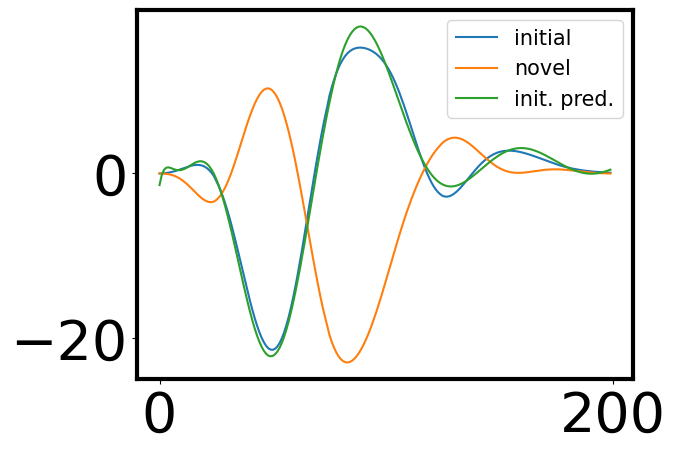

In [97]:
gains = np.ones((NN,))
integrate_dynamics_res = integrate_dynamics(W_rec, gains, params, initial_cond)

target_pred = readout_fun(integrate_dynamics_res['R'][:,:n_exc], readout)

plt.plot(initial_target, label='initial')
plt.plot(novel_target, label='novel')
plt.plot(target_pred, label='init. pred.')

plt.legend(fontsize=15)
plt.show()

In [102]:
# integrate_dynamics_res_save = {}
# for k in ['t', 'X', 'R']:
#     integrate_dynamics_res_save[k] = integrate_dynamics_res[k]
    
# np.save('../integrate_dynamics_res', integrate_dynamics_res_save)

In [53]:
group_numbers = np.arange(params.num_groups)
group_index = np.repeat(group_numbers, NN // params.num_groups)
if len(group_index) < NN:
    group_index = np.append(group_index, 
                            np.random.choice(group_numbers, NN-len(group_index)))
# randomy shuffle
group_index = np.random.choice(group_index, NN)

In [62]:
# initial_output.shape, novel_target.shape

array([142,  31, 129, 125, 117,   4, 136, 120,  93, 156,  88, 125, 159,
        76,  13,  45,  62, 109,   9,  64,  88,  54,  84, 178, 146,  63,
        31, 106,  11,  58, 108,  92,   0,  66, 144,  40,  24,   8, 152,
        75,  53,  99,  35, 144, 160, 134,  62, 129,  71, 173, 184, 195,
        72,  83,  44,  34,  22, 164,  29, 155, 156,  15,  82,  56, 118,
       165,  53, 132,  12, 116, 160, 113,   1,  50,  56,  81,  72, 172,
       149,  91,  43, 110,  12,  17,  99,  41, 189, 142,  46, 127, 150,
       190,   8,   8,  98,  90,  98,  25, 177,  36,  26,  60,  86, 100,
       143, 157, 179,  23, 195, 128,  85,  70,  39, 132, 120, 196,  85,
        66,  75, 124,  16,  87, 102, 157,  76, 147, 132,  65,  71,  88,
       135,  80,  67, 139, 126,  92, 123,  94, 117, 199,  58,  62, 159,
       102,  63,  44, 194,   5, 132, 180, 100, 135, 173, 173, 168,  28,
        68, 147,  53,  23,   8, 116,  67, 113,  19,  63,  14,  42,  84,
       143,  67, 151,  22,  19,  63,  90,  90, 197,  60,  58, 14

array([5, 7, 0, 4, 2, 2, 1, 5, 5, 0, 6, 4, 2, 4, 1, 7, 4, 2, 2, 3, 6, 2,
       1, 2, 4, 7, 7, 1, 7, 7, 0, 7, 6, 0, 2, 0, 2, 0, 5, 7, 0, 5, 1, 2,
       4, 7, 4, 0, 5, 6, 5, 7, 2, 4, 4, 2, 4, 4, 0, 2, 0, 5, 4, 5, 2, 7,
       0, 0, 2, 7, 4, 4, 6, 0, 5, 5, 2, 7, 3, 2, 4, 3, 2, 4, 5, 1, 5, 5,
       2, 7, 7, 5, 0, 0, 3, 3, 3, 0, 4, 1, 4, 5, 0, 2, 0, 1, 2, 5, 7, 2,
       4, 0, 3, 0, 5, 1, 4, 0, 7, 0, 1, 7, 3, 1, 4, 6, 0, 7, 5, 6, 2, 2,
       1, 0, 1, 7, 7, 6, 2, 2, 7, 4, 2, 3, 7, 4, 4, 1, 0, 1, 2, 2, 6, 6,
       2, 2, 2, 6, 0, 5, 0, 7, 1, 4, 5, 7, 2, 4, 1, 0, 1, 7, 4, 5, 7, 3,
       3, 7, 5, 7, 2, 0, 0, 5, 6, 2, 4, 0, 2, 4, 7, 2, 1, 7, 3, 2, 0, 2,
       4, 2], dtype=int32)

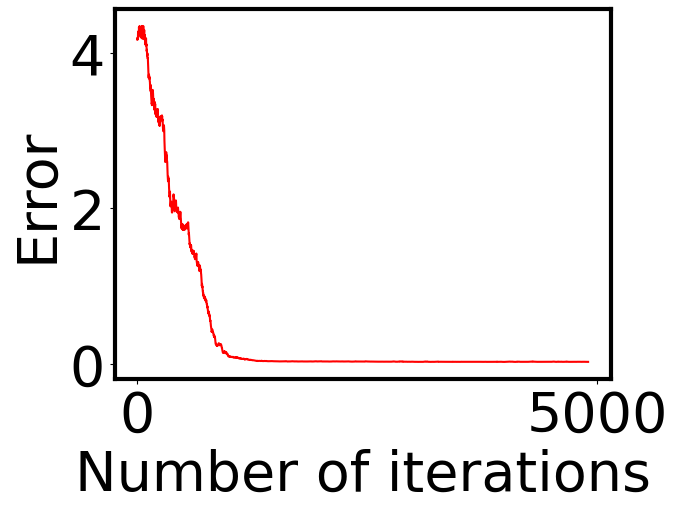

Iteration: 4900, trial: 0


In [88]:
n_trials = 1
trials_gains = []

group_index = y_cluster_range[6]

for trial_i in range(n_trials):

    # Initialize parameters
    error = np.zeros((params.num_iterations))
    T_ss = np.sum((novel_target - np.mean(novel_target)) ** 2)
    gains = np.ones((NN, params.num_iterations))

    dynamics = integrate_dynamics(W_rec, gains[:, 0], params, initial_cond)
    # dynamics = integrate_dynamics(W_rec, gains[:, 0], {'n_timepoints': n_timepoints}, initial_cond)

    design = np.zeros((params.n_timepoints, n_exc + 1)) 
    design[:, 0] = 1
    design[:, 1:] = dynamics['R'][:, :n_exc]

    initial_output = np.dot(design, readout)
    error[0] = np.sum((initial_output - novel_target) ** 2) / T_ss

    output = np.zeros((params.n_timepoints, params.num_iterations))
    output[:, 0] = initial_output

    alpha = 0.3
    gains_bar = gains[:, 0]
    error_bar = error[0]
    R = 0

    for iteration in range(1, params.num_iterations):
        xi = 0.001 * np.random.randn(params.num_groups)

        gains[:, iteration] = gains[:, iteration - 1] + R * (gains[:, iteration - 1] - gains_bar) + xi[group_index]

        dynamics = integrate_dynamics(W_rec, gains[:, iteration], params, initial_cond)
        design[:, 1:] = dynamics['R'][:, :n_exc]

        output[:, iteration] = np.dot(design, readout)
        error[iteration] = np.sum((output[:, iteration] - novel_target) ** 2) / T_ss

        R = np.sign(error_bar - error[iteration])
        error_bar = alpha * error_bar + (1 - alpha) * error[iteration]
        gains_bar = alpha * gains_bar + (1 - alpha) * gains[:, iteration]

        if iteration % 100 == 0:
            clear_output()
            plt.plot(error[:iteration], 'r')
            plt.ylabel('Error')
            plt.xlabel('Number of iterations')
            plt.pause(0.01)
            print(f"Iteration: {iteration}, trial: {trial_i}")

    plt.show()
    
    trials_gains.append(gains[:, iteration])
    
trials_gains = np.stack(trials_gains, -1)

In [89]:
# np.sum((output[:, iteration] - novel_target) ** 2) / T_ss

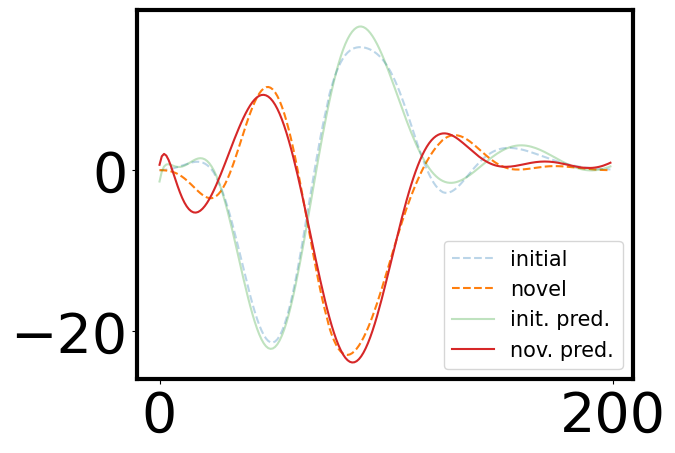

In [91]:
plt.plot(initial_target, label='initial', linestyle='--', alpha=0.3)
plt.plot(novel_target, label='novel', linestyle='--')
plt.plot(target_pred, label='init. pred.', alpha=0.3)
plt.plot(output[:, iteration], label='nov. pred.')

plt.legend(fontsize=15)
plt.show()

# Clustering

In [72]:
trials_gains.shape

(200, 10)

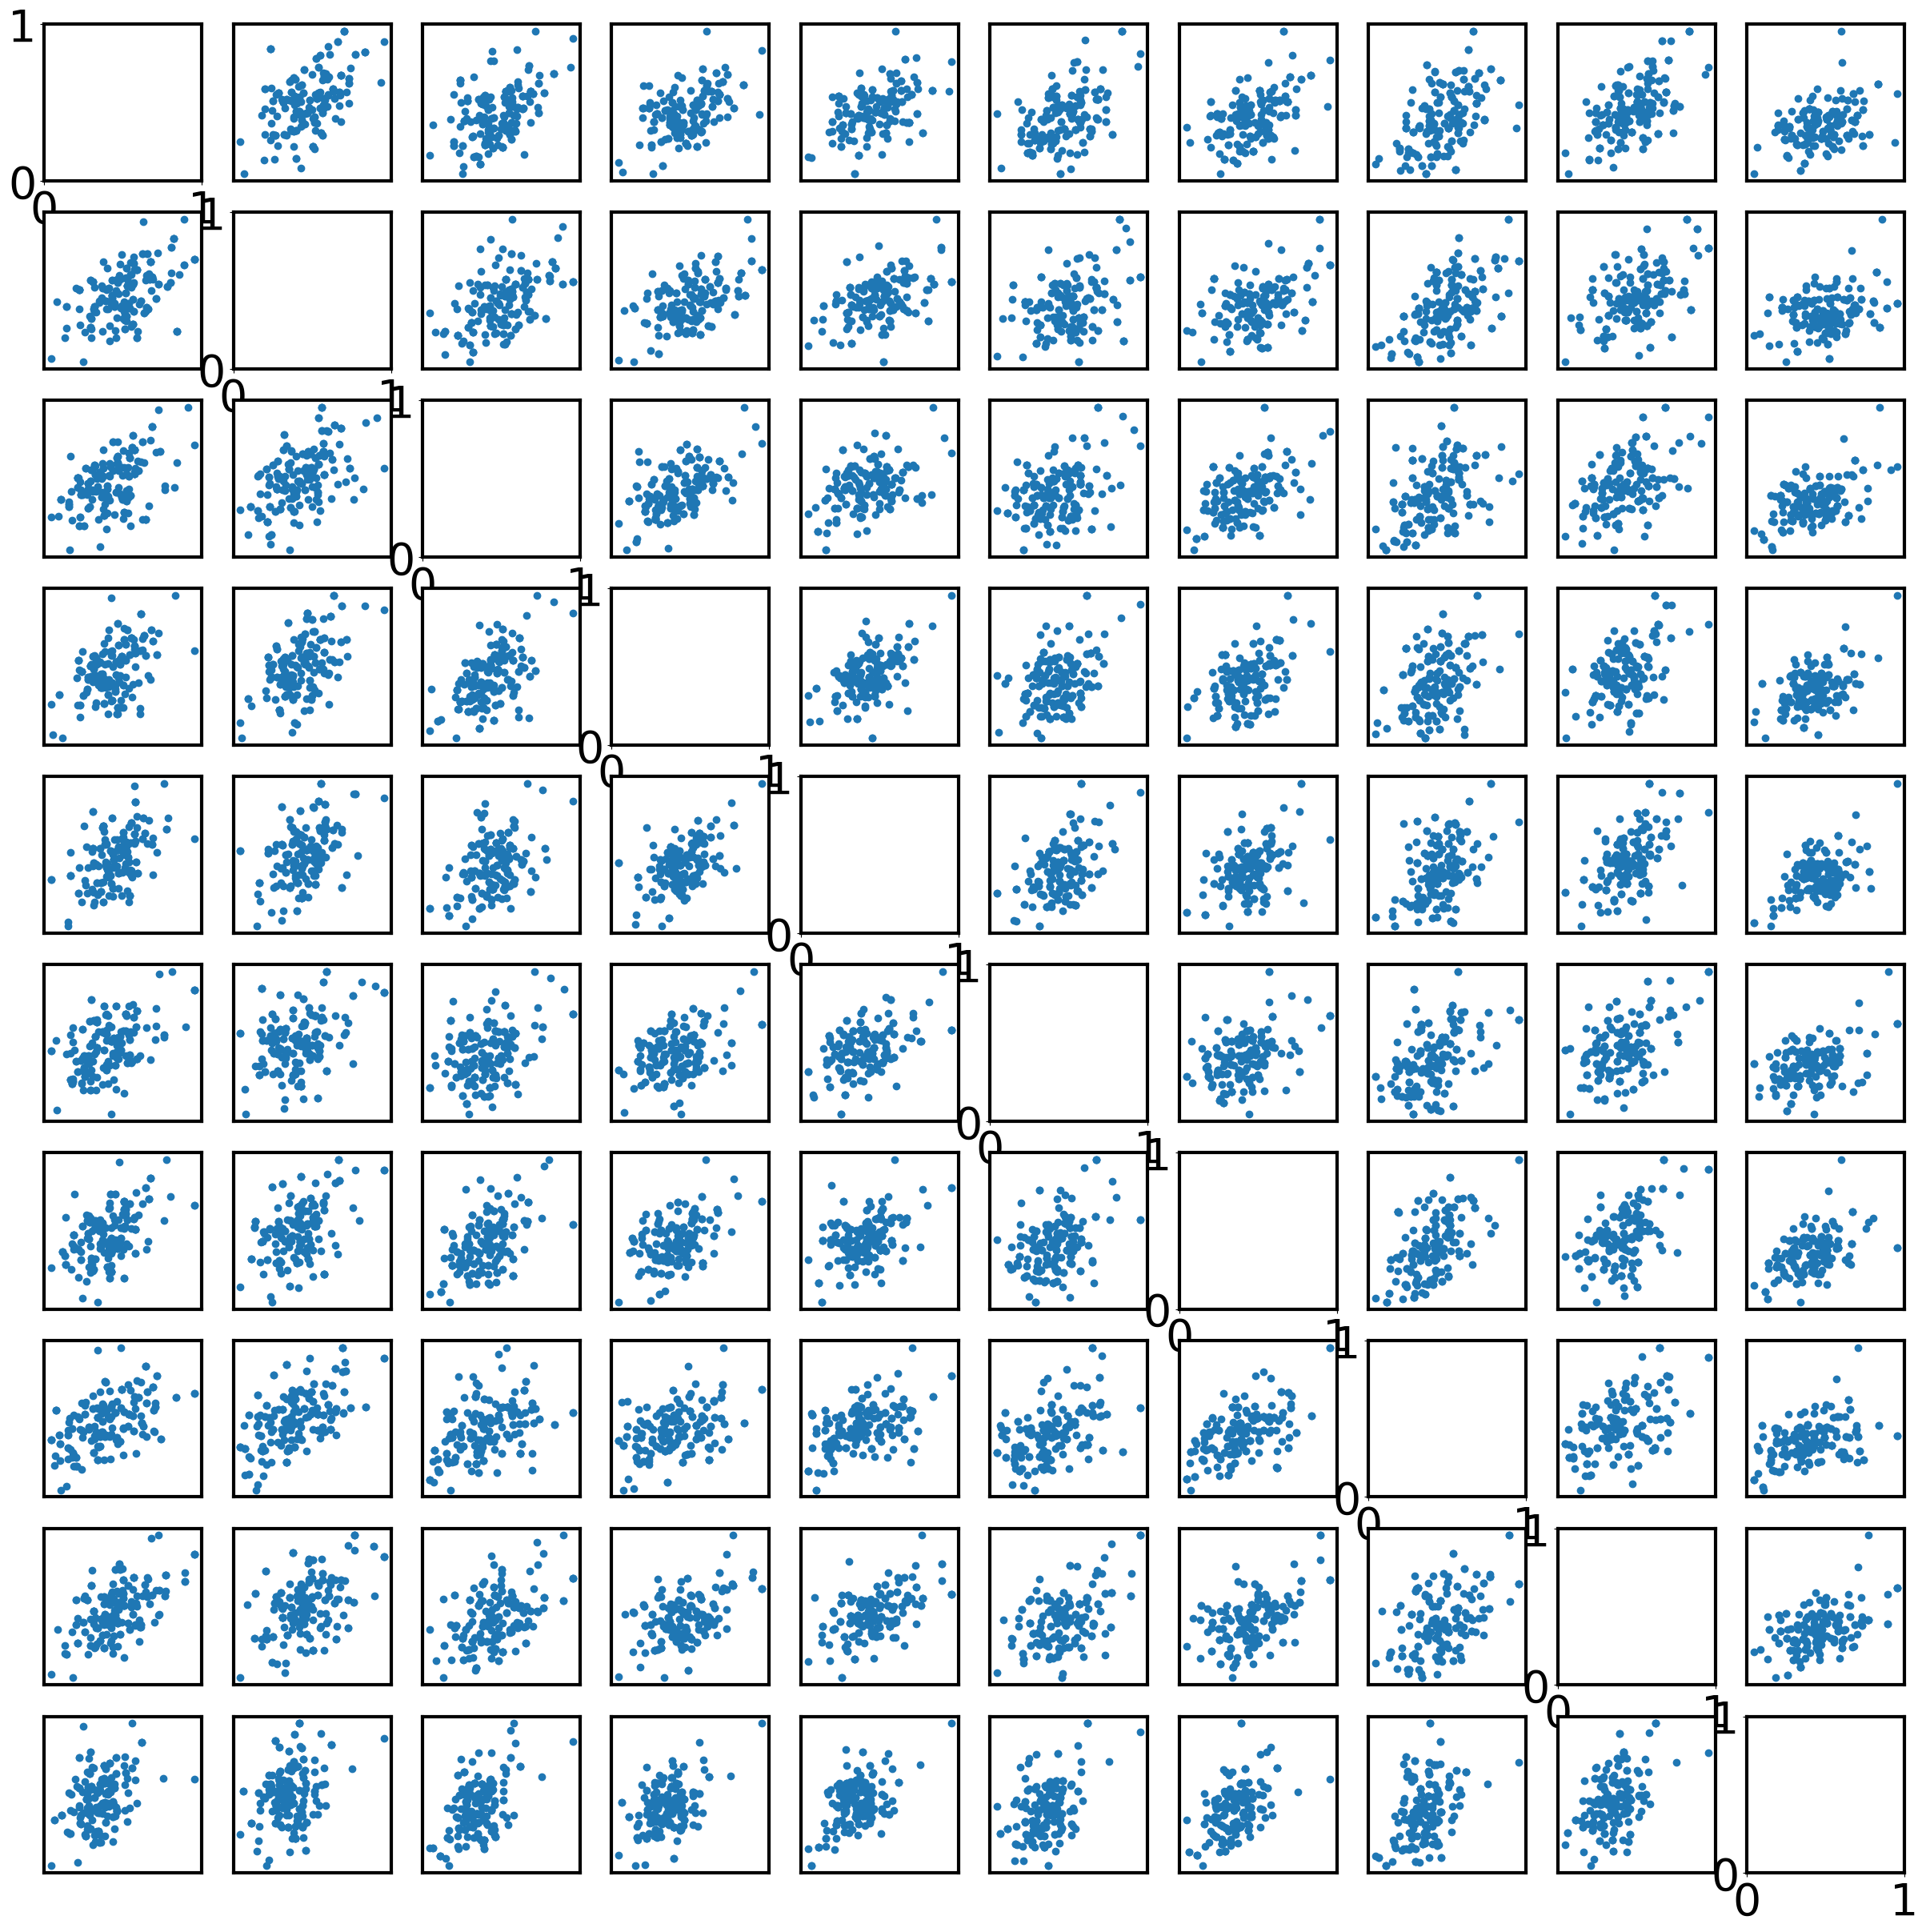

In [73]:
# plt.scatter(g_matrix[:,0], g_matrix[:,5])
n_g_iter = 10
fig, axes = plt.subplots(ncols=n_g_iter, nrows=n_g_iter, figsize=(n_g_iter*3, n_g_iter*3))
for i in range(n_g_iter):
    for j in range(n_g_iter):  
        if i != j:
            axes[i,j].scatter(trials_gains[:,i], trials_gains[:,j])
            axes[i,j].set_xticks([])        
            axes[i,j].set_yticks([])                

In [82]:
n_clusters_range = np.arange(2,20)
clustering_metrics = defaultdict(list)
y_cluster_range = []

for n_cl in tqdm(n_clusters_range):
    kmeans = KMeans(n_clusters=n_cl, n_init=1, random_state=42)
    y = kmeans.fit_predict(trials_gains)
    y_cluster_range.append(y)
    
    clustering_metrics['sihouette'].append(silhouette_score(trials_gains, y))
    clustering_metrics['dbindex'].append(davies_bouldin_score(trials_gains, y))    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 327.88it/s]


In [85]:
y_cluster_range[6]

array([5, 7, 0, 4, 2, 2, 1, 5, 5, 0, 6, 4, 2, 4, 1, 7, 4, 2, 2, 3, 6, 2,
       1, 2, 4, 7, 7, 1, 7, 7, 0, 7, 6, 0, 2, 0, 2, 0, 5, 7, 0, 5, 1, 2,
       4, 7, 4, 0, 5, 6, 5, 7, 2, 4, 4, 2, 4, 4, 0, 2, 0, 5, 4, 5, 2, 7,
       0, 0, 2, 7, 4, 4, 6, 0, 5, 5, 2, 7, 3, 2, 4, 3, 2, 4, 5, 1, 5, 5,
       2, 7, 7, 5, 0, 0, 3, 3, 3, 0, 4, 1, 4, 5, 0, 2, 0, 1, 2, 5, 7, 2,
       4, 0, 3, 0, 5, 1, 4, 0, 7, 0, 1, 7, 3, 1, 4, 6, 0, 7, 5, 6, 2, 2,
       1, 0, 1, 7, 7, 6, 2, 2, 7, 4, 2, 3, 7, 4, 4, 1, 0, 1, 2, 2, 6, 6,
       2, 2, 2, 6, 0, 5, 0, 7, 1, 4, 5, 7, 2, 4, 1, 0, 1, 7, 4, 5, 7, 3,
       3, 7, 5, 7, 2, 0, 0, 5, 6, 2, 4, 0, 2, 4, 7, 2, 1, 7, 3, 2, 0, 2,
       4, 2], dtype=int32)

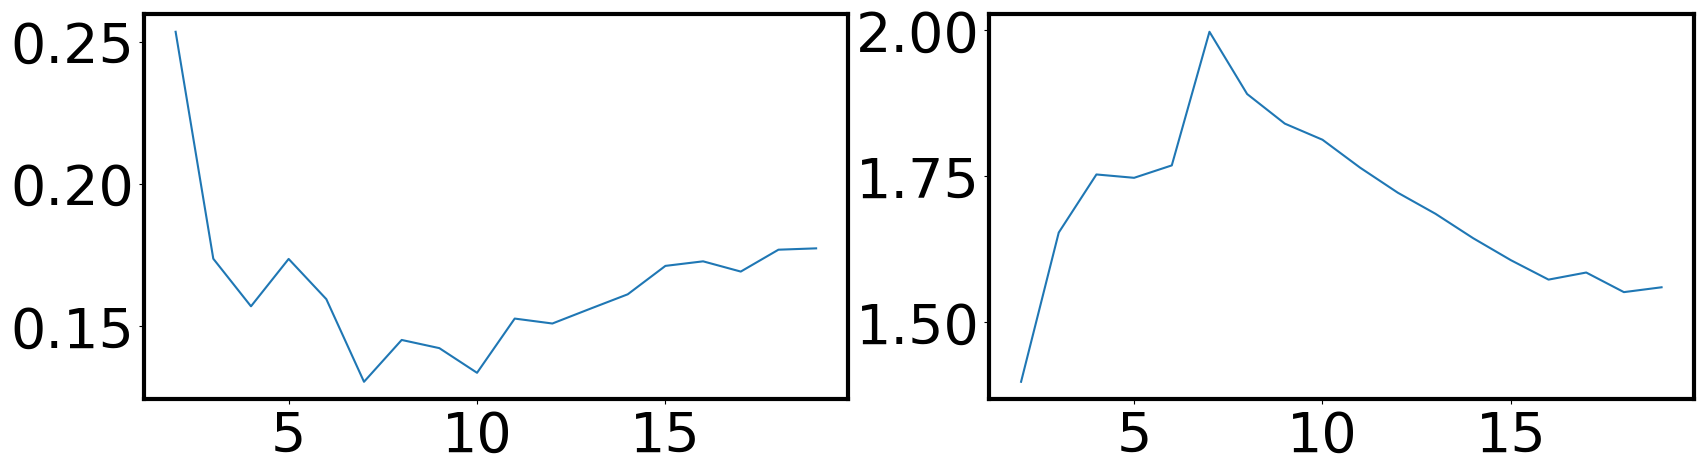

In [83]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
ax1.plot(n_clusters_range, clustering_metrics['sihouette'])
ax2.plot(n_clusters_range, clustering_metrics['dbindex'])
plt.show()